In [1]:
from raco.backends.spark.connection import SparkConnection
from raco.backends.spark.catalog import SparkCatalog
from raco.backends.spark.algebra import SparkAlgebra
from raco.backends.myria.connection import MyriaConnection
from raco.backends.myria.catalog import MyriaCatalog
from raco.backends.myria import MyriaLeftDeepTreeAlgebra
from raco.backends.federated.connection import FederatedConnection
from raco.backends.federated.catalog import FederatedCatalog
from raco.backends.federated import FederatedAlgebra
from raco.backends.federated.algebra import FederatedExec
from raco.compile import optimize

import raco.myrial.interpreter as interpreter
import raco.myrial.parser as myrialparser
from optparse import OptionParser

import raco.viz

import os


Successfully imported Spark Modules


In [2]:
def get_myria_connection():
    rest_url = 'https://rest.myria.cs.washington.edu:1776'
    execution_url = 'http://demo.myria.cs.washington.edu'
    connection = MyriaConnection(rest_url=rest_url,
                                 execution_url=execution_url)
    return connection


In [3]:
def get_spark_connection():
    connection = SparkConnection('local')
    return connection


In [4]:
program_mcl = """
matA = scan('/users/shrainik/downloads/sample_small.dat');

-- define constant values as singleton tables.
epsilon = [0.001];
prunelimit = [0.00001];

-- initialize oldChaos and newChaos for stop condition.
oldchaos = [1000];
newchaos = [1000];

-- while there is an epsilon improvement
do
    oldchaos = newchaos;

    -- square matA
    A = [from matA emit col as col_a, row as row_a, value as val_a];
    B = [from matA emit col as col_b, row as row_b, value as val_b];
    AxA = [from A, B
           where col_a == row_b
           emit row_a as row, col_b as col, sum(val_a * val_b) as value];

    -- inflate operation
    -- value will be value^2
    squareA = [from AxA emit row, col, value * value as value];

    colsums = [from squareA
               emit squareA.col as col_c, sum(squareA.value) as colsum];

    -- normalize newMatA
    newMatA = [from squareA, colsums
               where squareA.col == colsums.col_c
               emit squareA.row as row, squareA.col as col, squareA.value/colsums.colsum as value];

    -- pruning
    prunedA = [from newMatA
               where value > *prunelimit
               emit *];

    -- calculate newchaos
    colssqs = [from prunedA
               emit prunedA.col as col_sqs, sum (prunedA.value * prunedA.value) as sumSquare];
    colmaxs = [from prunedA
               emit prunedA.col as col_max, max (prunedA.value) as maxVal];

    newchaos = [from colmaxs, colssqs
                where colmaxs.col_max == colssqs.col_sqs
                emit max (colmaxs.maxVal - colssqs.sumSquare)];

    -- prepare for the iteration.
    matA = prunedA;

    -- check the convergency.
    continue = [from newchaos, oldchaos emit (*oldchaos - *newchaos) > *epsilon];
while continue;

store (newchaos, '/users/shrainik/downloads/output.dat');
"""


In [5]:
myriaconn = get_myria_connection()
sparkconn = get_spark_connection()


In [6]:
myriacatalog = MyriaCatalog(myriaconn)
sparkcatalog = SparkCatalog(sparkconn)


In [7]:
myrial_code = program_mcl

In [8]:
catalog = FederatedCatalog([myriacatalog, sparkcatalog])
parser = myrialparser.Parser()
processor = interpreter.StatementProcessor(catalog, True)
statement_list = parser.parse(myrial_code)
processor.evaluate(statement_list)

algebras = [MyriaLeftDeepTreeAlgebra(), SparkAlgebra()]
falg = FederatedAlgebra(algebras, catalog)


[('row', 'LONG_TYPE'), ('col', 'LONG_TYPE'), ('value', 'LONG_TYPE')]


In [9]:
logical = processor.get_logical_plan()
federated_plan = processor.get_physical_plan(target_alg=falg)

[('row', 'LONG_TYPE'), ('col', 'LONG_TYPE'), ('value', 'LONG_TYPE')]


In [10]:
dot_logical = raco.viz.operator_to_dot_object(logical)


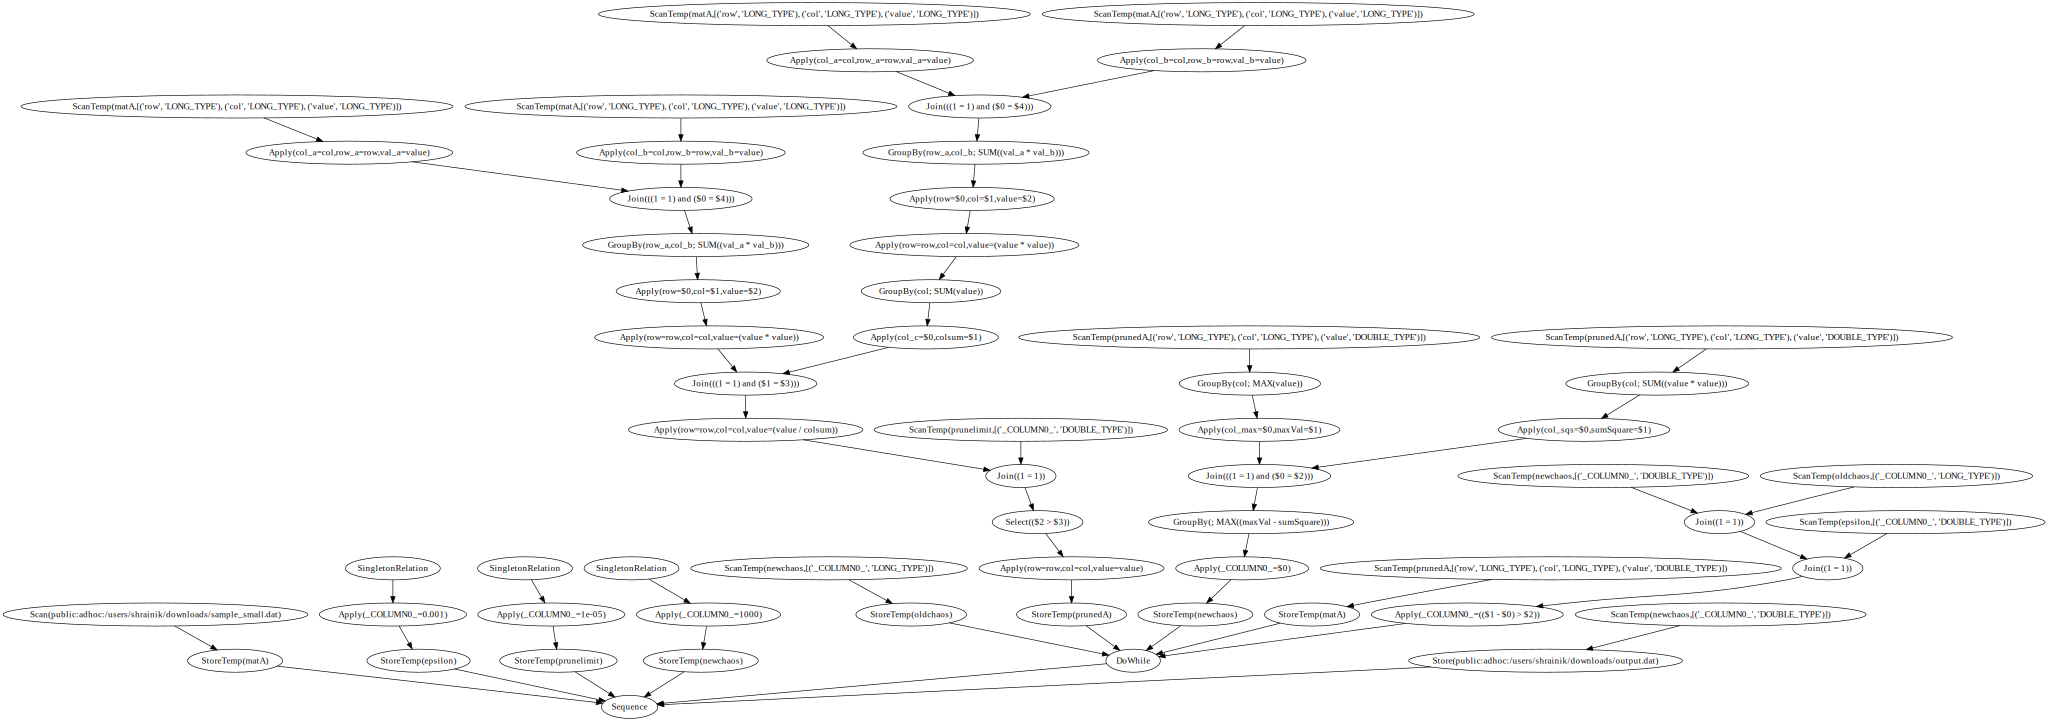

In [11]:
dot_logical

In [12]:
dot_federated = raco.viz.operator_to_dot_object(federated_plan)
dot_federated

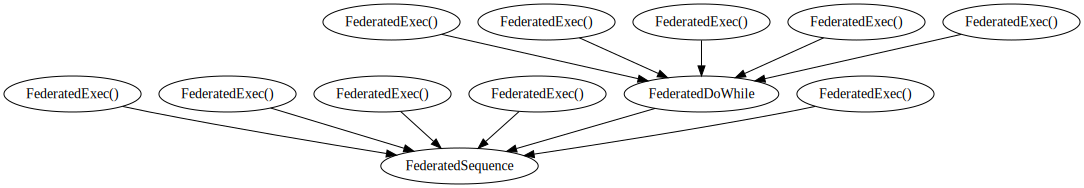

In [14]:
physical_plan_spark = optimize(federated_plan, SparkAlgebra())

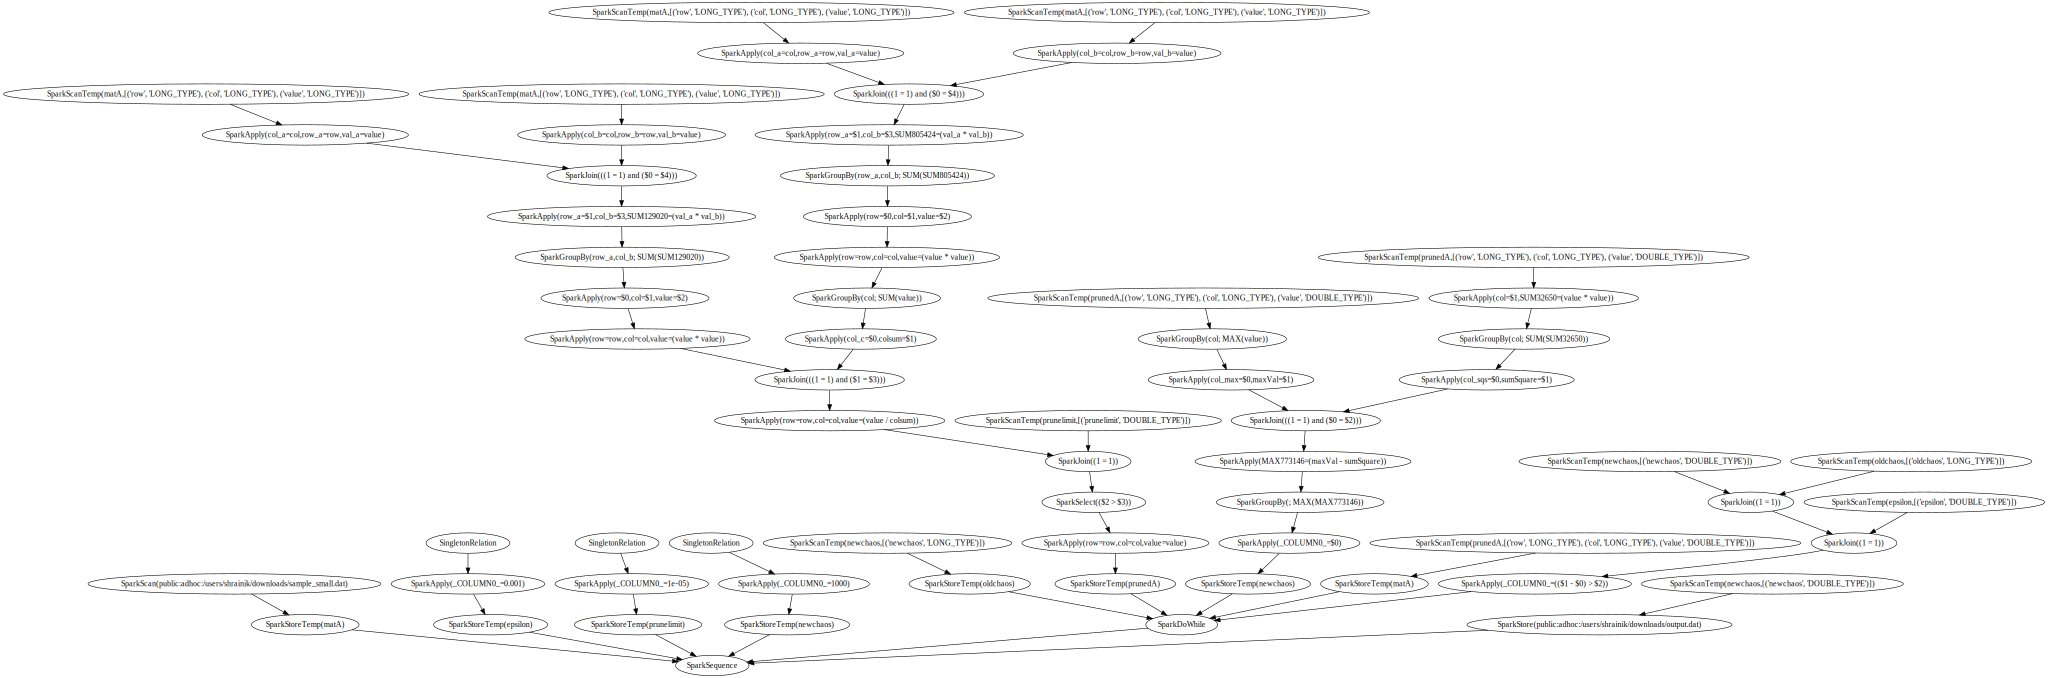

In [17]:
phys_dot = raco.viz.operator_to_dot_object(physical_plan_spark)
phys_dot

In [18]:
sparkconn.execute_query(physical_plan_spark)

+--------+
|newchaos|
+--------+
|    null|
+--------+

